In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
data=pd.read_csv("Output/X_train_formateado.csv")
data.date=pd.to_datetime(data.date)
data.head(3)

,asset_id,group_id,week,weekday,t1,t2,t3,t4,total_t,week_day,date,day
0,1,2,1,1,NaN,NaN,19.0,0.0,2,1_1,2018-01-01,1
1,1,2,1,2,NaN,NaN,8.0,0.0,2,1_2,2018-01-02,2
2,1,2,1,3,NaN,NaN,9.0,0.0,2,1_3,2018-01-03,3


## Agruparar por asset e implementar Holt-Winters una medición de 1 asset

In [3]:
data=data.set_index('asset_id')
porAsset=data.groupby(data.index)

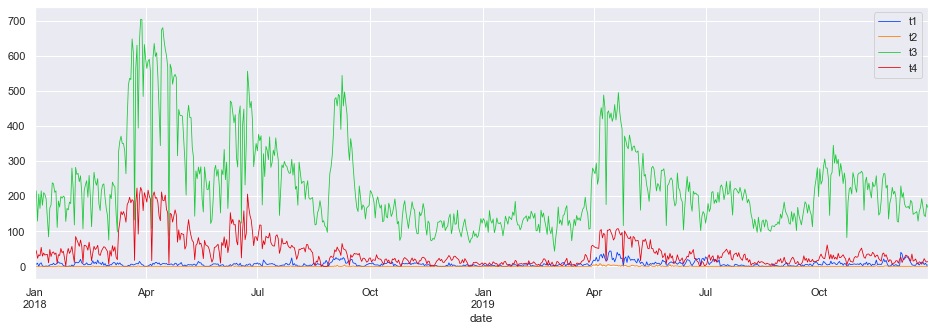

In [4]:
ASSET=50
mediciones=["t1","t2","t3","t4"]
asset = porAsset.get_group(ASSET).reset_index().set_index('date')

# Gráfica de la serie de tiempo de las 4 mediciones
sns.set(rc={'figure.figsize':(16,5)}, palette="bright")
asset[mediciones].plot(linewidth=0.8)

C:\Users\anais\miniconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\anais\miniconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


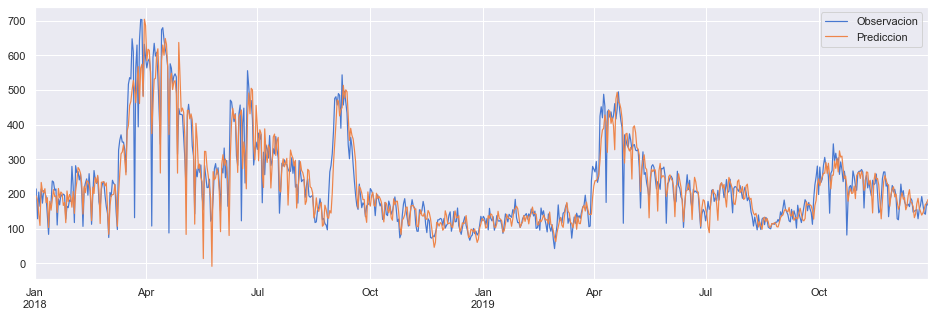

In [5]:
ASSET=50
t="t3"
asset = porAsset.get_group(ASSET).reset_index().set_index('date')

#Entrenar modelo
model=ExponentialSmoothing(asset[t],seasonal='add',seasonal_periods=7, freq="D").fit()
#Guardar el valor de gama
gamma=model.params['smoothing_seasonal']
#Guardar los resultados del modelo
results=model.summary()
#Predecir el modelo
prediction = model.predict(start=asset[t].index[0], end=asset[t].index[-1])
#Graficar la comparación de las observaciones y las predicciones
comparacion=pd.DataFrame({"Observacion":asset[t], "Prediccion":prediction})
sns.set(rc={'figure.figsize':(16,5)}, palette="muted")
comparacion.plot(linewidth=1.2)


C:\Users\anais\miniconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\anais\miniconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


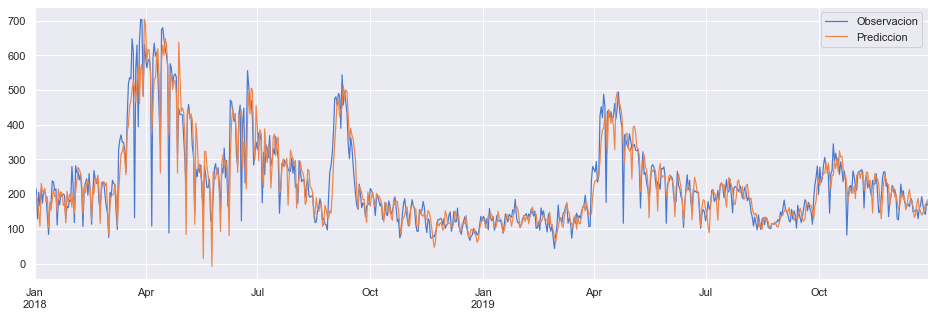

In [6]:
t="t3"

#Entrenar modelo
model=ExponentialSmoothing(asset[t], trend='add', seasonal='add', seasonal_periods=7, freq="D").fit()
#Guardar el valor de gamma
gamma=model.params['smoothing_seasonal']
#Guardar los resultados del modelo
results=model.summary()
#Predecir el modelo
prediction = model.predict(start=asset[t].index[0], end=asset[t].index[-1])
#Graficar la comparación de las observaciones y las predicciones
comparacion=pd.DataFrame({"Observacion":asset[t], "Prediccion":prediction})
sns.set(rc={'figure.figsize':(16,5)}, palette="muted")
comparacion.plot(linewidth=1.2)


In [7]:
print(gamma)

0.19756555290756533


### Brutlag Algorithm


In [8]:
PERIOD = 7                                  
GAMMA = gamma    # debería ser gamma resultante del modelo Holt-Winter model -variable 'gama'
M = 2           # Factor de escalamiento de los márgenes de confianza del algrotmo brutlag, 
                # toma un valor entre 2 y 3 (ver referencia 3)z
    
UB = []         # margen de confianza superior 
LB = []         # margen de confianza inferior

difference_array = []
dt = []
difference_table = {"actual": asset[t], "predicted": prediction, "difference": difference_array, "UB": UB, "LB": LB}

### Cálculo de los márgenes de confianza mediante el algoritmo brutlag 
for i in range(len(prediction)):
    diff = asset[t][i]-prediction[i]
    if i < PERIOD:
        dt.append(GAMMA*abs(diff))
        UB.append(prediction[i]+M*dt[i])
        LB.append(prediction[i]-M*dt[i])
    else:
        dt.append(GAMMA*abs(diff) + (1-GAMMA)*dt[i-1])
        UB.append(prediction[i]+M*dt[i-PERIOD])
        LB.append(prediction[i]-M*dt[i-PERIOD])

    difference_array.append(diff)

difference = pd.DataFrame(difference_table)

print("\nDifference between actual and predicted\n")
difference


Difference between actual and predicted



,actual,predicted,difference,UB,LB
2018-01-01,183.0,198.178534,-15.178534,204.176046,192.181023
2018-01-02,215.0,193.323259,21.676741,201.888414,184.758104
2018-01-03,129.0,181.824774,-52.824774,202.697485,160.952063
2018-01-04,206.0,143.392082,62.607918,168.130418,118.653746
2018-01-05,165.0,107.822121,57.177879,130.414879,85.229362
...,...,...,...,...,...
2019-12-25,168.0,146.026276,21.973724,182.492071,109.560480
2019-12-26,145.0,156.346897,-11.346897,189.666969,123.026824
2019-12-27,142.0,170.880021,-28.880021,204.058647,137.701395
2019-12-28,177.0,172.460508,4.539492,222.404037,122.516978


Observaciones clasificadas como altas anomalías:  69
Observaciones clasificadas como bajas anomalías:  42
Observaciones clasificadas como normales 617


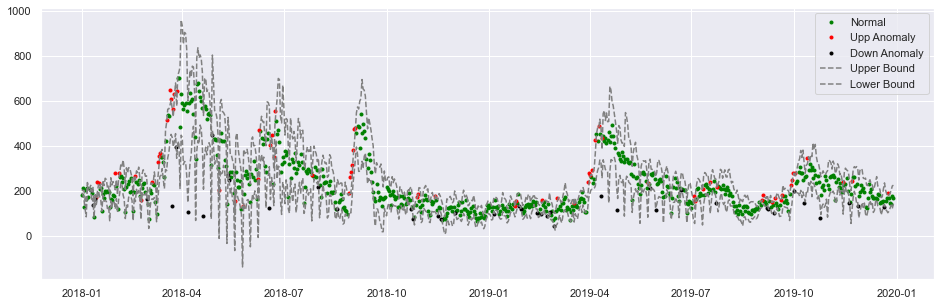

In [9]:
### Clasificacion de las observaciones como normales o anómalas
normal = []
normal_date = []
up_anomaly = []
up_anomaly_date = []
down_anomaly =[]
down_anomaly_date=[]

for i in range(len(asset[t])):
    if (UB[i] <= asset[t][i])  and i > PERIOD:
        up_anomaly_date.append(asset.index[i])
        up_anomaly.append(asset[t][i])
    elif (LB[i] >= asset[t][i])and i > PERIOD:
        down_anomaly_date.append(asset.index[i])
        down_anomaly.append(asset[t][i])
    else:
        normal_date.append(asset.index[i])
        normal.append(asset[t][i])

up_anomaly = pd.DataFrame({"date": up_anomaly_date, "value": up_anomaly})
up_anomaly.set_index('date', inplace=True)
down_anomaly = pd.DataFrame({"date": down_anomaly_date, "value": down_anomaly})
down_anomaly.set_index('date', inplace=True)
normal = pd.DataFrame({"date": normal_date, "value": normal})
normal.set_index('date', inplace=True)

print("Observaciones clasificadas como altas anomalías: ", up_anomaly.shape[0])
print("Observaciones clasificadas como bajas anomalías: ", down_anomaly.shape[0])
print("Observaciones clasificadas como normales", normal.shape[0])

#Visualización de anomalias y márgenes de confianza
sns.set(rc={'figure.figsize':(16,5)}, palette="muted")
plt.plot(normal.index, normal, '.', color='green',)
plt.plot(up_anomaly.index, up_anomaly, '.', color='red')
plt.plot(down_anomaly.index, down_anomaly, '.', color='black')

plt.plot(asset.t1.index, difference.UB, linestyle='--', color='grey')
plt.plot(asset.t1.index, difference.LB, linestyle='--', color='grey')

plt.legend(['Normal', 'Upp Anomaly', 'Down Anomaly','Upper Bound', 'Lower Bound'])
plt.show()